In [3]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature

In [4]:
!pip install ipython-autotime

%load_ext autotime

# Opening datasets

In [5]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 101 ms


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [525]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(n=500, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 435 ms


In [526]:
# so neste caso q n vamos usar transportation
df = df.loc[df['scene_label'] != 'transportation']

time: 2.9 ms


In [527]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(500, 3)
(500, 3)
(0, 3)
time: 5.87 ms


Reading the datasets and storing it to 'signals'

In [528]:
info_sound = df[['filename','scene_label']].to_numpy()
LABELS = ['indoor', 'outdoor']

time: 2.75 ms


In [529]:
dic_signals = {x:[] for i, x in enumerate(LABELS)}

for filename, label in info_sound:
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        dic_signals[label].append(sf.read(os.path.join(DIR_AUDIO, filename)))

time: 20.6 s


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [530]:
PARTS = 10
def get_features(dic_signals)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(y, sr):
        return librosa.feature.spectral_centroid(y=y, sr=sr)
    def get_flatness(y):
        return librosa.feature.spectral_flatness(y=y)
    def get_rms(y):
        return librosa.feature.rms(y=y)
    def get_mfccs(y, sr):
        return librosa.feature.mfcc(y=y, sr=sr)

    feats = (np.zeros((1,47))[0])
    
    j = 1
    k = 0 #label
    for label, signals in dic_signals.items():
        for signal, samplerate in signals:
            music_features = []
            signal = signal[:,0]
            for second in np.array_split(signal, PARTS):
                arr_mfcc = []
                #print(second.shape)
                c = get_centroid(second, samplerate)
                f = get_flatness(second)
                r = get_rms(second)
                mfccs = get_mfccs(second, samplerate)
                #print(np.array(mfccs).shape)
                mfccs = [[np.mean(x), np.std(x)] for x in mfccs]
                mfccs = np.array(mfccs).reshape(1,-1)[0]
                #print(mfccs.shape)
                mfccs = np.array_split(mfccs, mfccs.shape[0])
                #print(np.array(mfccs).shape)
                [arr_mfcc.append(x[0]) for x in mfccs]
                music_features = np.hstack([arr_mfcc, np.array([np.mean(c),np.std(c),np.mean(f), np.std(f),r[0][0], k, j])]) 
                #print(np.array(music_features).shape)
                
                feats = np.vstack([feats, music_features])  
            j += 1
            
        k += 1
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)
        


time: 31 ms


In [531]:
df = get_features(dic_signals)

time: 5min 36s


In [532]:
df.to_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv")

time: 881 ms


In [533]:
df = pd.read_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv").drop("Unnamed: 0",axis=1) 
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,-562.925087,21.557439,138.058267,14.475740,19.548143,7.791383,12.999026,9.100077,21.600209,9.719561,14.446969,5.627485,-2.576167,4.428390,18.317060,6.451234,10.958898,5.390129,-1.539831,6.407789,12.046936,4.550069,5.993121,4.566461,-0.212437,4.507098,8.500691,3.945843,2.442358,4.589298,4.401256,4.109399,3.373647,4.083005,11.001438,3.896518,-1.535348,4.203145,6.301597,3.566660,2786.683923,590.658169,0.001828,0.001386,0.002695,0.0,1.0
1,-557.469763,21.423113,148.473070,15.753278,11.277962,9.873125,14.374558,7.776245,18.654184,7.553699,14.698216,5.129454,-6.335096,3.801285,14.954548,5.400034,4.686633,5.804493,-1.906151,5.615217,8.911077,4.739704,7.500518,4.471556,-0.236668,4.829023,8.625020,5.135550,2.422326,4.171912,5.397360,4.762204,4.861893,4.533939,9.063538,4.334617,-0.178061,4.083193,4.844873,3.842130,2555.332338,621.289560,0.002321,0.002289,0.002236,0.0,1.0
2,-557.826734,17.797689,144.215180,17.299450,13.237813,10.163732,15.597461,8.671955,19.922340,7.424054,13.089926,6.041027,-7.515270,5.406003,18.674454,5.412973,6.736416,5.541688,-1.387005,4.789728,7.602748,5.642747,6.957588,5.658691,1.752386,4.010099,9.400265,4.409694,1.891518,4.590440,4.972433,3.711086,5.069213,4.100052,10.317221,4.003902,-0.826737,4.966742,4.236677,3.948591,2636.393362,608.160756,0.002042,0.001431,0.002089,0.0,1.0
3,-564.837991,10.325538,136.452400,18.311582,14.551319,11.336260,22.049716,8.915737,22.695058,8.641306,15.597456,7.342367,-4.216336,4.296949,15.508378,6.214872,8.328776,5.826851,0.360668,4.906668,5.219446,3.892365,5.428690,4.253783,-0.139583,5.322097,6.066279,5.049504,1.498407,5.300840,4.920706,4.377648,3.972729,3.853207,9.160785,3.761516,0.987406,3.307352,6.310424,4.095321,2856.009138,679.813423,0.002606,0.002189,0.003531,0.0,1.0
4,-556.727705,14.154986,134.698260,16.621376,10.758485,10.911171,23.601323,11.976850,23.360294,11.256270,12.557841,6.413851,-5.103297,5.260980,14.651687,5.484503,8.624370,5.007130,-3.410873,6.350446,4.757722,4.916879,5.701298,4.877757,-1.292029,3.863764,7.295893,4.182422,4.481379,4.547165,1.889533,5.517273,4.351304,4.545364,8.831758,4.427440,-1.445808,4.541405,3.480489,5.613662,2981.665514,588.791668,0.003400,0.002200,0.002064,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,-527.830624,19.040884,191.925136,13.594751,-6.193248,6.743418,12.700438,6.571598,1.271014,5.054141,16.399009,5.319381,-12.598424,5.128355,13.074940,6.778945,-4.547147,5.717908,0.889105,4.746984,11.838059,4.201645,7.596507,4.372635,-0.303508,4.962722,9.148821,5.191171,5.975397,5.109185,0.071615,5.563705,4.553782,4.725842,1.742721,5.648740,-3.076012,5.229517,1.360327,4.283767,1783.449353,508.222726,0.001011,0.001386,0.003866,1.0,928.0
9276,-535.071091,14.592935,184.324360,12.620068,4.141564,9.694817,12.791219,6.426007,1.232148,7.156266,16.933985,5.163304,-13.027973,5.807204,16.559619,5.937944,-4.414662,5.528523,1.770438,4.572071,6.771228,4.310731,7.592553,5.032670,1.602578,4.522250,8.773250,4.309606,5.439583,5.229881,-2.495087,4.303143,8.018587,4.859980,1.386139,4.642257,1.020707,4.174909,0.165801,3.626852,1811.461018,344.515110,0.000993,0.000748,0.004078,1.0,928.0
9277,-523.545702,16.427510,187.408304,18.480519,2.301807,10.601395,7.612114,6.720525,5.995486,7.628704,19.563367,6.773303,-12.160259,6.253705,10.492162,4.809261,-1.916240,4.749008,-1.934721,4.584789,5.205770,4.651786,5.353075,5.586241,-0.668536,5.247905,5.630593,5.137175,3.256163,6.157019,-0.733849,5.813028,3.258515,3.728679,2.941924,3.882308,0.156097,4.584797,5.460295,5.764061,1813.692862,476.571107,0.001178,0.001307,0.004962,1.0,928.0
9278,-509.211703,17.713635,185.998471,20.938434,3.016172,12.683511,11.007599,6.676198,2.432505,7.890611,12.777539,7.341508,-18.685137,7.967061,9.834174,5.033893,-1.0174

time: 211 ms


In [534]:
from sklearn.model_selection import GroupShuffleSplit

time: 1.12 ms


Split no dataframe baseado em grupos do número da música

In [535]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 2).split(df, groups=df['46']))

time: 4.38 ms


In [536]:
train_inds

array([   0,    1,    2, ..., 9277, 9278, 9279])

time: 2.88 ms


In [537]:
test_inds

array([  70,   71,   72, ..., 9177, 9178, 9179])

time: 2.99 ms


In [538]:
import random

time: 666 µs


In [539]:
X_train = (df.iloc[train_inds, 0:-2])
X_test = (df.iloc[test_inds,0:-2])
y_train = (df.iloc[train_inds,[-2,-1]]).values
y_test = (df.iloc[test_inds,[-2,-1]]).values

time: 10.1 ms


In [540]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7420, 45), (1860, 45), (7420, 2), (1860, 2))

time: 2.76 ms


In [541]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

time: 1.18 ms


In [542]:
scaler.fit(X_train.values)
X_train = scaler.transform(X_train.values)
X_test = scaler.transform(X_test.values)

time: 11.5 ms


In [543]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

time: 1.23 ms


# Building a KNN Model

In [544]:
def get_k_accuracy(X_train, X_test, y_train, y_test): 
    def knn_classifier(k, X_train, X_test, y_train, y_test):
        #print(y_train)
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        #print(y_pred)
        return metrics.accuracy_score(y_test,y_pred)

    def plot_scores(x,y):
        fig, a = plt.subplots(1, figsize = (10, 8))
        title = "Accuracy Score by K values"
        plt.title(title)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        a.plot(x, y)

    k_range = range(1,15)
    scores = {}
    scores_list = []

    for k in k_range:
        scores[k] = knn_classifier(k, X_train, X_test, y_train, y_test)
        scores_list.append(scores[k])

    plot_scores(list(k_range), scores_list)
    print('Accuracy: ' + str(scores[max(scores, key= scores.get)]))
    return max(scores, key= scores.get)



time: 14.6 ms


Accuracy: 0.8381720430107527


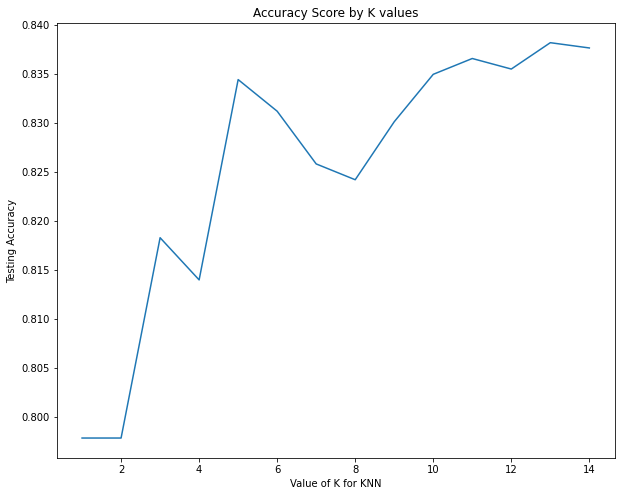

time: 19.1 s


In [545]:
k = get_k_accuracy(X_train,X_test, y_train[:,0], y_test[:,0])
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train[:,0])
y_pred = knn.predict(X_test)

In [546]:
from collections import Counter

time: 782 µs


Contagem das predições para cada música

In [547]:
(y_test, y_pred)

(array([[  0.,   8.],
        [  0.,   8.],
        [  0.,   8.],
        ...,
        [  1., 918.],
        [  1., 918.],
        [  1., 918.]]), array([1., 0., 0., ..., 1., 1., 1.]))

time: 4.7 ms


In [548]:
counts = dict()
for id in np.unique(y_test[:,1]):
    counts[id] = []
print(counts)
for t, p in zip(y_test, y_pred):
    counts[t[1]].append(p)

counter = [Counter(y) for x,y in counts.items()]
counter

{8.0: [], 16.0: [], 19.0: [], 21.0: [], 23.0: [], 38.0: [], 63.0: [], 66.0: [], 68.0: [], 69.0: [], 71.0: [], 75.0: [], 85.0: [], 92.0: [], 100.0: [], 102.0: [], 108.0: [], 110.0: [], 129.0: [], 138.0: [], 142.0: [], 143.0: [], 144.0: [], 147.0: [], 153.0: [], 159.0: [], 161.0: [], 165.0: [], 170.0: [], 173.0: [], 180.0: [], 184.0: [], 186.0: [], 189.0: [], 193.0: [], 194.0: [], 198.0: [], 206.0: [], 210.0: [], 213.0: [], 227.0: [], 231.0: [], 232.0: [], 237.0: [], 249.0: [], 251.0: [], 252.0: [], 258.0: [], 259.0: [], 268.0: [], 273.0: [], 274.0: [], 276.0: [], 292.0: [], 294.0: [], 296.0: [], 306.0: [], 312.0: [], 313.0: [], 316.0: [], 323.0: [], 328.0: [], 331.0: [], 334.0: [], 336.0: [], 345.0: [], 346.0: [], 364.0: [], 366.0: [], 380.0: [], 385.0: [], 388.0: [], 397.0: [], 400.0: [], 401.0: [], 413.0: [], 418.0: [], 420.0: [], 428.0: [], 438.0: [], 439.0: [], 440.0: [], 441.0: [], 448.0: [], 452.0: [], 461.0: [], 466.0: [], 471.0: [], 474.0: [], 481.0: [], 482.0: [], 485.0: [], 48

[Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 5, 1.0: 5}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 3, 1.0: 7}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 2, 1.0: 8}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 10}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 2, 1.0: 8}),
 Counter({0.0: 10}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({1.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 7, 1.0: 3}),
 Counter({0.0: 6, 1.0: 4}),
 Counter({0.0: 10}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 8, 1.0: 2}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 2, 1.0: 8}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 10}),
 Counter({0.0: 9, 1.0: 1}),
 Counter({0.0: 3, 1.

time: 18.4 ms


Votação das predições

In [583]:
music_y_pred = [max(x, key=x.get) for x in counter]
music_y_test = np.unique(y_test, axis=0)[:,0]

time: 2.91 ms


In [584]:
metrics.accuracy_score(music_y_test,music_y_pred)

0.8817204301075269

time: 3.02 ms


In [555]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(3)
trans_pca = pca.fit_transform(X_test)
trans_pca = pd.DataFrame(trans_pca)
trans_pca['Labels'] = y_test[:,0]
trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
trans_pca.head()

,PC1,PC2,PC3,Labels
0,1.408937,0.568961,-1.219159,0.0
1,0.246279,0.407876,-1.813330,0.0
2,6.811812,0.979790,0.435639,0.0
3,0.920515,0.172324,-0.982046,0.0
4,-1.156709,1.183420,-1.961186,0.0


time: 43.2 ms


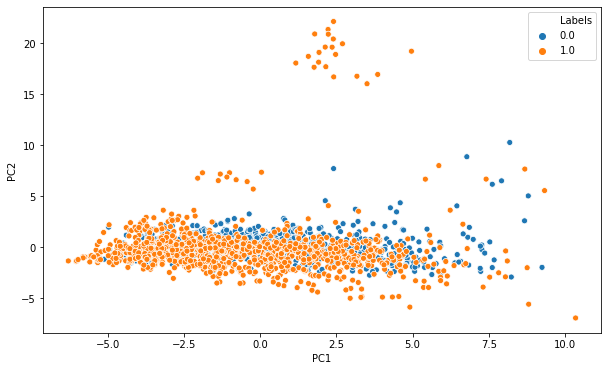

time: 357 ms


In [558]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

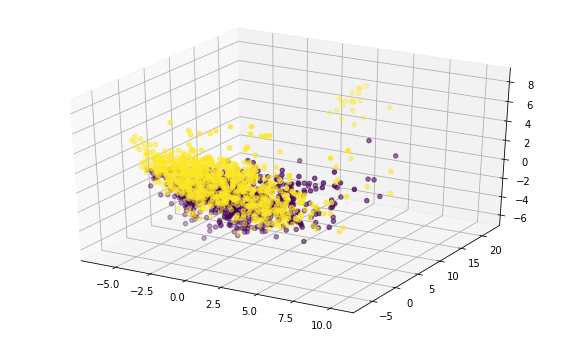

time: 184 ms


In [582]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection="3d")
ax.scatter3D(trans_pca['PC1'], trans_pca['PC2'], trans_pca['PC3'], c=trans_pca['Labels']);
plt.show()